In [1]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import os
import time
pd.set_option('display.max_rows', 200)
%matplotlib inline

# Import Data 

In [2]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

### Appeals

In [3]:
# main table 
tblAppeal = pd.read_csv(os.path.join(DATAFOLDER, 'data/raw/tblAppeal.csv'), low_memory=False) 
print(tblAppeal.info())
tblAppeal.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870388 entries, 0 to 870387
Data columns (total 17 columns):
idnAppeal             870388 non-null int64
idncase               868758 non-null float64
idnProceeding         776380 non-null float64
strAppealCategory     870388 non-null object
strAppealType         870388 non-null object
datAppealFiled        870226 non-null object
strFiledBy            870378 non-null object
datAttorneyE27        521008 non-null object
datBIADecision        847196 non-null object
strBIADecision        847180 non-null object
strBIADecisionType    822882 non-null object
strCaseType           824855 non-null object
strLang               773811 non-null object
strNat                777004 non-null object
strProceedingIHP      367364 non-null object
strCustody            666356 non-null object
strProbono            1880 non-null object
dtypes: float64(2), int64(1), object(14)
memory usage: 112.9+ MB
None


,idnAppeal,idncase,idnProceeding,strAppealCategory,strAppealType,datAppealFiled,strFiledBy,datAttorneyE27,datBIADecision,strBIADecision,strBIADecisionType,strCaseType,strLang,strNat,strProceedingIHP,strCustody,strProbono
169571,172228,2942374.0,1267654.0,IJ,MTR BIA,1996-09-30 00:00:00,A,1996-09-30 00:00:00,1997-06-04 00:00:00,GRN,P,DEP,SP,GT,NaN,NaN,NaN
574780,4746901,3769221.0,2140911.0,IJ,MTR BIA,2006-07-06 00:00:00,B,2006-07-06 00:00:00,2007-02-08 00:00:00,NJU,P,RMV,SP,MX,NaN,R,NaN
861485,5036624,6610008.0,5316902.0,IJ,Case Appeal,2013-12-09 00:00:00,A,2013-12-09 00:00:00,NaN,NaN,NaN,RMV,SP,MX,NaN,N,NaN


In [4]:
# drop appeals with no case number, proceeding number, or decision 
tblAppeal.dropna(subset=['idncase', 'idnProceeding', 'strBIADecision'], inplace=True) 
tblAppeal = tblAppeal[tblAppeal['idnProceeding'] != 0] # drop zeros 

# convert indexes to integers 
tblAppeal['idncase'] = tblAppeal['idncase'].astype(int) 
tblAppeal['idnProceeding'] = tblAppeal['idnProceeding'].astype(int) 
tblAppeal.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755222 entries, 0 to 869457
Data columns (total 17 columns):
idnAppeal             755222 non-null int64
idncase               755222 non-null int64
idnProceeding         755222 non-null int64
strAppealCategory     755222 non-null object
strAppealType         755222 non-null object
datAppealFiled        755060 non-null object
strFiledBy            755212 non-null object
datAttorneyE27        478717 non-null object
datBIADecision        755222 non-null object
strBIADecision        755222 non-null object
strBIADecisionType    731103 non-null object
strCaseType           755180 non-null object
strLang               752329 non-null object
strNat                754061 non-null object
strProceedingIHP      365943 non-null object
strCustody            643730 non-null object
strProbono            1842 non-null object
dtypes: int64(3), object(14)
memory usage: 103.7+ MB


In [5]:
# format column types 
tblAppeal['datAppealFiled_dt'] = pd.to_datetime(tblAppeal['datAppealFiled'], errors='coerce')
tblAppeal['datBIADecision_dt'] = pd.to_datetime(tblAppeal['datBIADecision'], errors='coerce')
tblAppeal['datAppealFiled_year'] = tblAppeal['datAppealFiled_dt'].dt.year

In [6]:
# code lookup tables 
bia_appeal_category = pd.read_excel(os.path.join(DATAFOLDER, 'data/raw/BIA Appeal Data File code translations.xlsx'), 
                                    sheetname='BIA Appeal Category', skip_footer=7)
bia_appeal_type = pd.read_excel(os.path.join(DATAFOLDER, 'data/raw/BIA Appeal Data File code translations.xlsx'),
                                sheetname='BIA Appeal Type', skip_footer=3)
bia_decision_type = pd.read_excel(os.path.join(DATAFOLDER, 'data/raw/BIA Appeal Data File code translations.xlsx'),
                                  sheetname='BIA decision type', skip_footer=2)
bia_decision_code = pd.read_excel(os.path.join(DATAFOLDER, 'data/raw/BIA Appeal Data File code translations.xlsx'),
                                  sheetname='BIA decision code', skip_footer=2)

In [7]:
# join them 
tblAppeal_df = tblAppeal.merge(bia_appeal_category, how='left', left_on='strAppealCategory', right_on='Code')\
                        .rename(columns={'Description': 'strAppealCategoryDesc'}).drop('Code', axis=1)\
                        .merge(bia_appeal_type, how='left', left_on='strAppealType', right_on='Code')\
                        .rename(columns={'Description': 'strAppealTypeDesc'}).drop('Code', axis=1)\
                        .merge(bia_decision_code, how='left', left_on='strBIADecision', right_on='Code')\
                        .rename(columns={'Description': 'strBIADecisionDesc'}).drop('Code', axis=1)\
                        .merge(bia_decision_type, how='left', left_on='strBIADecisionType', right_on='Code')\
                        .rename(columns={'Description': 'strBIADecisionTypeDesc'}).drop('Code', axis=1)
print(tblAppeal_df.info()) 
tblAppeal_df.sample(10).T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755222 entries, 0 to 755221
Data columns (total 24 columns):
idnAppeal                 755222 non-null int64
idncase                   755222 non-null int64
idnProceeding             755222 non-null int64
strAppealCategory         755222 non-null object
strAppealType             755222 non-null object
datAppealFiled            755060 non-null object
strFiledBy                755212 non-null object
datAttorneyE27            478717 non-null object
datBIADecision            755222 non-null object
strBIADecision            755222 non-null object
strBIADecisionType        731103 non-null object
strCaseType               755180 non-null object
strLang                   752329 non-null object
strNat                    754061 non-null object
strProceedingIHP          365943 non-null object
strCustody                643730 non-null object
strProbono                1842 non-null object
datAppealFiled_dt         755060 non-null datetime64[ns]
datB

,644773,245260,323821,313294,173959,86915,53402,143366,631973,377895
idnAppeal,4883090,4432857,4524299,4512816,4349857,87054,53490,164380,4867885,4582724
idncase,5830460,3855025,4432646,3995131,3353309,3053706,2403206,2507229,3686155,4481947
idnProceeding,4744172,2243438,3007592,2435215,1647716,1400634,567386,695414,2040440,3065872
strAppealCategory,IJ,IJ,IJ,IJ,IJ,IJ,IJ,IJ,IJ,IJ
strAppealType,Case Appeal,Case Appeal,Appeal of IJ MTR,Case Appeal,Bond Appeal,Case Appeal,Case Appeal,Case Appeal,Circuit Court Remand,Appeal of IJ MTR
datAppealFiled,2009-10-22 00:00:00,1999-09-14 00:00:00,2002-04-19 00:00:00,2001-12-31 00:00:00,1997-06-05 00:00:00,1993-05-06 00:00:00,1989-12-27 00:00:00,1990-11-05 00:00:00,2009-06-01 00:00:00,2003-06-12 00:00:00
strFiledBy,A,A,A,I,A,A,A,A,O,A
datAttorneyE27,2009-10-22 00:00:00,NaN,2002-04-19 00:00:00,NaN,NaN,1994-03-09 00:00:00,1989-12-27 00:00:00,1990-11-05 00:00:00,2009-07-14 00:00:00,2003-06-12 00:00:00
datBIADecision,2010-01-21 00:00:00,2001-03-27 00:00:00,2003-04-23 00:00:00,2003-01-23 00:00:00,1998-02-13 00:00:00,1995-03-13 00:00:00,1991-01-02 00:00:00,1991-01-12 00:00:00,2009-10-29 00:00:00,2004-01-22 00:00:00
strBIADecision,DIS,NJU,REM,TPS,WDL,OTH,D30,TPS,DVD,SAF


In [8]:
# some strBIADecision don't have corresponding code translations; to remove 
print(tblAppeal_df[pd.isnull(tblAppeal_df['strBIADecisionDesc'])]['strBIADecision'].value_counts()) 
tblAppeal_df.dropna(subset=['strBIADecisionDesc'], inplace=True)

DSO    5987
DED    2107
CPG    1704
ABC    1606
APD    1170
GRS     431
DNS     421
ADM     355
DMO     238
CPC      90
MB       88
SNC      82
AFD      54
RET      52
ADD      18
CGR      16
TPD      16
REV      13
WPD       5
SUP       4
          2
Name: strBIADecision, dtype: int64


### Master Proceedings

In [9]:
master = pd.read_csv(os.path.join(DATAFOLDER, 'data/raw/master.csv')) 
print(master.info())
master.sample(5)

/Users/Gary/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084437 entries, 0 to 6084436
Data columns (total 16 columns):
idncase             float64
nat                 object
case_type           object
c_asy_type          object
idnproceeding       object
base_city_code      object
hearing_loc_code    object
dec_type            object
dec_code            object
other_comp          object
osc_date            object
input_date          object
comp_date           object
attorney_flag       float64
ij_code             object
tracid              float64
dtypes: float64(3), object(13)
memory usage: 742.7+ MB
None


,idncase,nat,case_type,c_asy_type,idnproceeding,base_city_code,hearing_loc_code,dec_type,dec_code,other_comp,osc_date,input_date,comp_date,attorney_flag,ij_code,tracid
1471516,3178517.0,CH,EXC,E,1553744,NYC,NYC,O,E,NaN,08NOV1992,12NOV1992,12MAY1994,1.0,SK,329.0
2467447,3967698.0,MX,RMV,NaN,2394082,PIS,PIS,7,X,NaN,12DEC1999,09FEB2000,14FEB2000,1.0,ET,63.0
1861507,3490880.0,MX,DEP,NaN,1811503,ATL,ATD,O,D,NaN,30NOV1995,20DEC1995,21DEC1995,NaN,WAC,4.0
900981,2735478.0,MX,RMV,NaN,1002594,ELO,ELO,O,X,NaN,19OCT2000,02NOV2000,07DEC2000,NaN,WLA,51.0
4785400,6173084.0,MX,RMV,NaN,4763921,BLM,BLM,W,X,NaN,12FEB2009,20FEB2009,20FEB2009,NaN,KWO,14.0


In [10]:
# check missing data 
master.isnull().sum()

idncase                  14
nat                   16775
case_type                15
c_asy_type          4449366
idnproceeding             0
base_city_code           24
hearing_loc_code       1516
dec_type            1519549
dec_code            1674748
other_comp          4744870
osc_date              33353
input_date            29744
comp_date            335076
attorney_flag       3044591
ij_code               39598
tracid               341914
dtype: int64

In [11]:
# look up tables 
master_case_type = pd.read_csv(os.path.join(DATAFOLDER, 'data/raw/master_case_type.csv'))
master_decision_type = pd.read_csv(os.path.join(DATAFOLDER, 'data/raw/master_decision_type.csv'))

master_decision_on_proceeding = pd.read_csv(os.path.join(DATAFOLDER, 'data/raw/master_decision_on_proceeding.csv'))
master_decision_on_proceeding.drop(master_decision_on_proceeding.tail(2).index, inplace=True)
master_decision_on_proceeding.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)

In [12]:
# add column to indicate whether decision was listed in dec_code or other_comp 
master['dec_col'] = np.where(pd.notnull(master['dec_code']), 'C', 'O') 
master['dec_judge'] = np.where(pd.notnull(master['dec_code']), master['dec_code'], master['other_comp']) 

In [13]:
# join to look up tables
master_df = master.merge(master_decision_type, how='left', left_on='dec_type', right_on='strCode')\
                  .rename(columns={'strDescription': 'dec_type_str'}).drop('strCode', axis=1)\
                  .merge(master_case_type, how='left', left_on='case_type', right_on='strCode')\
                  .rename(columns={'strDescription': 'case_type_str'}).drop('strCode', axis=1)\
                  .merge(master_decision_on_proceeding, how='left', left_on=['case_type', 'dec_judge', 'dec_col'], 
                         right_on=['strCaseType', 'strDecCode', 'strDecType'])\
                  .rename(columns={'strDecDescription': 'dec_code_str'}).drop(['strCaseType', 'strDecCode', 'strDecType'], axis=1)
master_df.sample(3)

,idncase,nat,case_type,c_asy_type,idnproceeding,base_city_code,hearing_loc_code,dec_type,dec_code,other_comp,...,input_date,comp_date,attorney_flag,ij_code,tracid,dec_col,dec_judge,dec_type_str,case_type_str,dec_code_str
4265499,5738219.0,CU,RMV,NaN,4217228,SNA,SNA,O,T,NaN,...,03MAY2007,27FEB2008,1.0,BAZ,184.0,C,T,oral decision,Removal,Terminated
1373852,3102451.0,MX,DEP,NaN,1459141,PIS,PIS,7,D,NaN,...,11MAY1992,15MAY1992,NaN,HEA,59.0,C,D,type of form where decision is deportation/rem...,Deportation,Deport
5784978,6981541.0,MX,RMV,E,5833612,ORL,ORL,NaN,NaN,NaN,...,16APR2012,NaN,1.0,SFK,392.0,O,NaN,NaN,Removal,NaN


### Master Proceedings (processed data from Daniel Chen)

In [27]:
# start_time = time.time() 
# master_dchen = pd.read_stata(os.path.join(DATAFOLDER,'data/decision_sched_merge_adjdate.dta')) 
# print("It took {}s to load dchen data".format(time.time() - start_time))

It took 406.234689951s to load dchen data


In [28]:
# master_dchen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5664753 entries, 0 to 5664752
Columns: 106 entries, idncase to flag_datemismatch
dtypes: category(12), float32(2), float64(50), int16(3), int32(3), int8(4), object(32)
memory usage: 3.7+ GB


In [29]:
# check for nulls 
# master_dchen.isnull().sum()

idncase                                 0
nat                                     0
case_type                               0
c_asy_type                              0
idnproceeding                           0
base_city_code                          0
hearing_loc_code                        0
dec_type                                0
dec_code                                0
other_comp                              0
attorney_flag                     2907462
ij_code                                 0
tracid                             248615
comp_year                               0
comp_month                              0
comp_day                                0
comp_date                               0
osc_year                            32420
osc_month                           32420
osc_day                             32420
osc_date                            32420
input_year                          27549
input_month                         27549
input_day                         

In [30]:
# master_dchen.sample(3).T

,4283348,2554499,1030515
idncase,6394324,4262784,2968605
nat,LE,ID,GT
case_type,RMV,RMV,RMV
c_asy_type,,I,I
idnproceeding,5042605,2794686,1298433
base_city_code,CHI,LOS,MIA
hearing_loc_code,CHI,LOS,MIA
dec_type,O,O,W
dec_code,T,V,X
other_comp,,,


In [31]:
# add column to indicate whether decision was listed in dec_code or other_comp 
# master_dchen['dec_col'] = np.where(pd.notnull(master_dchen['dec_code']), 'C', 'O') 
# master_dchen['dec_judge'] = np.where(pd.notnull(master_dchen['dec_code']), master_dchen['dec_code'], master_dchen['other_comp']) 

In [32]:
# join to look up tables
# master_dchen_df = master_dchen.merge(master_decision_type, how='left', left_on='dec_type', right_on='strCode')\
#                               .rename(columns={'strDescription': 'dec_type_str'}).drop('strCode', axis=1)\
#                               .merge(master_case_type, how='left', left_on='case_type', right_on='strCode')\
#                               .rename(columns={'strDescription': 'case_type_str'}).drop('strCode', axis=1)\
#                               .merge(master_decision_on_proceeding, how='left', 
#                                      left_on=['case_type', 'dec_judge', 'dec_col'], 
#                                      right_on=['strCaseType', 'strDecCode', 'strDecType'])\
#                               .rename(columns={'strDecDescription': 'dec_code_str'}).drop(['strCaseType', 'strDecCode', 'strDecType'], axis=1)
# master_dchen_df.sample(3).T

,2380481,449659,1968934
idncase,4127527,2466031,3791958
nat,MX,MX,JM
case_type,RMV,DEP,RMV
c_asy_type,I,,
idnproceeding,2610945,646451,2169407
base_city_code,SFR,HOU,NYC
hearing_loc_code,SFR,TDC,NYC
dec_type,O,,W
dec_code,V,,X
other_comp,,T,


### Master Proceedings (processed by Sagent/Dunn)

In [22]:
master_dunn = pd.read_csv(os.path.join(DATAFOLDER, 
                                       'data/AsylumAdj/data_for_model/_decision_scheduling_merge_final_converted.csv'), 
                          encoding='latin-1', low_memory=False) # gets UnicodeDecodeError otherwise 
master_dunn['in_dunn'] = 1 
master_dunn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602500 entries, 0 to 602499
Columns: 183 entries, Unnamed: 0 to in_dunn
dtypes: bool(1), float64(72), int64(40), object(70)
memory usage: 837.2+ MB


In [4]:
# dunn has far fewer proceedings than the original 
# print "Original master has {} data points, Dunn's has {}".format(len(master_dunn), len(master))

SyntaxError: invalid syntax (<ipython-input-4-4127eb7f00f7>, line 2)

In [15]:
# print(master_dunn.columns.tolist())

['Unnamed: 0', u'idncase', u'idnproceeding', u'nat', u'case_type', u'c_asy_type', u'base_city_code', u'hearing_loc_code', u'dec_type', u'dec_code', u'other_comp', u'attorney_flag', u'ij_code', u'tracid', u'case_type_string', u'_mcase', u'dec_type_string', u'_mdectype', u'outcome_recorded_in_field', u'dec_string', u'_mdecproceeddec', u'_mdecproceedoth', u'nat_string', u'_mnat', u'base_city_street', u'base_city_string', u'base_city_state', u'base_city_zip5', u'base_city_zip4', u'base_city_phone', u'_mbasecity', u'hearing_loc_string1', u'hearing_loc_string2', u'hearing_loc_street', u'hearing_loc_city', u'hearing_loc_state', u'hearing_loc_zip5', u'hearing_loc_phone', u'_mhearingloc', u'judge_name_caps', u'_mlookupijcode', u'idncode', u'idnproceedingappln', u'appl_code', u'appl_dec', u'_mappln', u'application_type_string', u'_mapplcode', u'application_dec_string', u'_mappldec', u'cityid', u'judgeid', u'natid', u'comp_year', u'comp_month', u'comp_day', u'comp_date', u'osc_year', u'osc_month'

In [93]:
#print master_dchen.columns.tolist()

['idncase', 'nat', 'case_type', 'c_asy_type', 'idnproceeding', 'base_city_code', 'hearing_loc_code', 'dec_type', 'dec_code', 'other_comp', 'attorney_flag', 'ij_code', 'tracid', 'comp_year', 'comp_month', 'comp_day', 'comp_date', 'osc_year', 'osc_month', 'osc_day', 'osc_date', 'input_year', 'input_month', 'input_day', 'input_date', 'lawyer', 'defensive', 'affirmative', 'case_type_string', '_mcase', 'dec_type_string', '_mdectype', 'outcome_recorded_in_field', 'dec_string', '_mdecproceeddec', '_mdecproceedoth', 'nat_string', '_mnat', 'base_city_street', 'base_city_string', 'base_city_state', 'base_city_zip5', 'base_city_zip4', 'base_city_phone', '_mbasecity', 'hearing_loc_string1', 'hearing_loc_string2', 'hearing_loc_street', 'hearing_loc_city', 'hearing_loc_state', 'hearing_loc_zip5', 'hearing_loc_phone', '_mhearingloc', 'judge_name_caps', '_mlookupijcode', 'cityid', 'judgeid', 'natid', 'venue_change', 'deport', 'relief_granted', 'remove', 'terminated', 'voluntary_departure', 'oral', 'wr

In [94]:
# master_dchen['asylum_only_proceeding'].value_counts()

0.0    5645688
1.0      18953
Name: asylum_only_proceeding, dtype: int64

In [95]:
# master_dunn['case_type_string'].value_counts()

REMOVAL                 408738
DEPORTATION             142533
EXCLUSION                39062
ASYLUM ONLY CASE          9669
WITHHOLDING ONLY          2487
CREDIBLE FEAR REVIEW         1
Name: case_type_string, dtype: int64

In [96]:
# master_dunn['asylum'].value_counts()

1    562348
0     40152
Name: asylum, dtype: int64

In [103]:
# determine what % of master proceedings that Dunn retained 
# master_dunn_pairs = master_dunn[['idncase', 'idnproceeding', 'grant']].copy()
# master_dunn_pairs['in_dunn'] = 1 
# master_dunn_delta = master_df[['idncase', 'idnproceeding', 'case_type_str']].merge(master_dunn_pairs, how='left', 
#                                                                                    on=['idncase', 'idnproceeding']) 
# master_dunn_delta['in_dunn'].fillna(0, inplace=True)
# master_dunn_delta.groupby(['case_type_str'])['in_dunn'].agg(['size', np.mean])

,size,mean
case_type_str,,
Asylum Only Case,19881,0.447261
Claimed Status Review,1262,0.000000
Continued Detention Review,42,0.000000
Credible Fear Review,7453,0.000134
Deportation,1429597,0.099371
Exclusion,258052,0.151125
NACARA Adjustment,470,0.000000
Reasonable Fear Case,3611,0.000000
Recission,2087,0.000000


# Merge Datasets (master, dunn, judge bio)

In [63]:
judge_bio = pd.read_csv(os.path.join(DATAFOLDER, 'data/AsylumAdj/data/cleaned_judge_bios.csv')) 
judge_bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Male_judge               367 non-null float64
Year_Appointed_SLR       367 non-null float64
Year_College_SLR         367 non-null float64
Year_Law_school_SLR      367 non-null float64
Government_Years_SLR     367 non-null float64
Govt_nonINS_SLR          367 non-null float64
INS_Years_SLR            367 non-null float64
Military_Years_SLR       367 non-null float64
NGO_Years_SLR            367 non-null float64
Privateprac_Years_SLR    367 non-null float64
Academia_Years_SLR       367 non-null float64
ij_code                  367 non-null object
dtypes: float64(11), object(1)
memory usage: 34.5+ KB


In [179]:
df = master_dunn.merge(tblAppeal_df, how='left', 
                       left_on=['idncase', 'idnproceeding'], right_on=['idncase', 'idnProceeding'])
df = df.merge(judge_bio, how='left', on='ij_code')

# Determine scope of appeal case types

In [180]:
df['appealed'] = np.where(pd.notnull(df['idnAppeal']), 1, 0) 
df['appealed'].value_counts() 

1    369933
0    332335
Name: appealed, dtype: int64

In [181]:
# check appeal and case types 
df.groupby(['strAppealTypeDesc', 'case_type_string']).size().unstack().fillna(0) 

case_type_string,ASYLUM ONLY CASE,DEPORTATION,EXCLUSION,REMOVAL,WITHHOLDING ONLY
strAppealTypeDesc,,,,,
Appeal of IJ MTR,93.0,2653.0,478.0,3026.0,9.0
Bond Appeal,10.0,569.0,7.0,2388.0,6.0
Bond MTR Reconsider,0.0,0.0,0.0,12.0,0.0
Bond MTR Reinstate,0.0,0.0,0.0,4.0,0.0
Bond MTR Reopen,0.0,0.0,0.0,10.0,0.0
Case Appeal,3878.0,66912.0,18341.0,173865.0,842.0
Circuit Court Remand,186.0,604.0,145.0,7058.0,26.0
Interlocutory Appeal,7.0,68.0,41.0,486.0,7.0
MTR BIA,1231.0,21833.0,5739.0,59309.0,87.0


In [182]:
# filter for relevant appeal types 
selected_appeal_types = ['Appeal of IJ MTR', 'Case Appeal', 'Circuit Court Remand', 'Interlocutory Appeal', 'MTR BIA'] 
df['appealed'] = np.where(df['strAppealTypeDesc'].isin(selected_appeal_types), df['appealed'], 0) 
df['appealed'].value_counts() 

1    366927
0    335341
Name: appealed, dtype: int64

In [183]:
# exclude government appeals (defined as original proceeding not granted)
df['appealed'] = np.where(df['grant'] == 0, df['appealed'], 0) 
df['appealed'].value_counts() 

1    355238
0    347030
Name: appealed, dtype: int64

In [184]:
# de-duplicate multiple appeals (each case-proceeding should be unique) by retaining the last appeal 
df = df.sort_values(by=['idncase', 'idnProceeding', 'datBIADecision_dt'], 
                    ascending=[True, True, False])
df.drop_duplicates(subset=['idncase', 'idnProceeding'], keep='first', inplace=True)
df['appealed'].value_counts() 

0    340595
1    258782
Name: appealed, dtype: int64

In [185]:
# determine appeal decision type 
positive_labels = ['Background Check Remand', 'Grant With No Remand', 'Granted', 'Remand', 
                   'Sustain', 'Temporary Protected Status', 'Termination']
negative_labels = ['Denied', "Dismiss Appeal/Affirm IJ's Decision", 'Dismissed (Grant V/D 30 days)', 
                   'Dismissed (Voluntary Departure Granted)', 'Rejection', 'SUMMARY AFFIRMANCE/VD', 
                   'Summary Affirmance', 'Summary Dismiss', 'Summary Dismissal (O) Other', 
                   'Summary Dismissal (a) inad reason on appeal', 'Summary Dismissal - Both (a) & (e)']

df['appeal_decision'] = np.where(df['appealed'] == 0, 'did_not_appeal', 
                                 np.where(df['strBIADecisionDesc'].isin(positive_labels), 'appeal_successful', 
                                          np.where(df['strBIADecisionDesc'].isin(negative_labels), 'appeal_denied', 
                                                   'appeal_neutral')))
df['appeal_decision'].value_counts()

did_not_appeal       340595
appeal_denied        163829
appeal_successful     78482
appeal_neutral        16471
Name: appeal_decision, dtype: int64

In [186]:
# exclude appeals with neutral decision outcomes 
df = df[df['appeal_decision'] != 'appeal_neutral'].copy()  
df['appealed'].value_counts() 

0    340595
1    242311
Name: appealed, dtype: int64

# Split into Appeals vs. Non-Appeals

In [187]:
# split into those who appealed vs. those who didn't 
appeals = df[df['appealed'] == 1].copy() 
non_appeals = df[df['appealed'] == 0].copy() 

In [188]:
# for those that appealed, drop those without mandatory features, and assign binary response label 
mandatory_features = ['idnAppeal', 'datAppealFiled_year', 'case_type_string'] 
appeals.dropna(subset=mandatory_features, inplace=True)
appeals['granted'] = np.where(appeals['appeal_decision'] == 'appeal_successful', 1, 0) 
appeals['granted'].astype(int)
print("{} of appeal were successful".format(float(appeals['granted'].sum()) / len(appeals)))

0.323922034822 of appeal were successful


# Output to CSV 

In [189]:
# subset variables to keep 
variables_to_keep = ['idncase', 'idnproceeding', 'idnAppeal', 'nat_string', 'ij_code', 'attorney_flag',
                     'lawyer', 'defensive', 'affirmative', 'oral', 'written', 'base_city_code', 'base_city_state', 
                     'hearing_loc_city', 'hearing_loc_code', 'hearing_loc_state', 'venue_change', 
                     'comp_year', 'comp_month', 'comp_day', 
                     'osc_year', 'osc_month', 'osc_day', 'input_year', 'input_month', 'input_day',
                     'adj_time_start', 'case_type_string', 'dec_type_string', 'dec_string',
                     'deport', 'relief_granted', 'remove', 'terminated', 'voluntary_departure', 
                     'deport_form', 'voluntary_form', 'deportation_proceeding', 
                     'exclusion_proceeding', 'removal_proceeding', 'asylum_only_proceeding', 
                     'withholding_only_proceeding', 'strCustody', 'strProbono', 'datAppealFiled_year'] 

In [190]:
# output to csv 
appeals_fp = os.path.join(DATAFOLDER, 'data_for_model/appeals_data_2018-05-13-v1.csv') 
appeals[variables_to_keep + ['granted']].to_csv(appeals_fp, encoding='utf-8', index=False)
appeals.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242262 entries, 498640 to 702259
Columns: 220 entries, Unnamed: 0 to granted
dtypes: bool(1), datetime64[ns](2), float64(86), int64(42), object(89)
memory usage: 406.9+ MB


# Additional Feature Engineering (to be reorganized with above)

In [190]:
# group judges with few sample sizes together 
grouped_judges = appeals_with_last_year['ij_code'].value_counts() 
grouped_judges = grouped_judges[grouped_judges < 50].index.tolist()
appeals_with_master['ij_code_grouped'] = np.where(appeals_with_master['ij_code'].isin(grouped_judges), 'other',
                                          appeals_with_master['ij_code'])
len(appeals_with_master['ij_code_grouped'].value_counts())

371

In [191]:
# group nationalities with few sample sizes together 
grouped_nat = appeals_with_last_year['nat_string'].value_counts() 
grouped_nat = grouped_nat[grouped_nat < 50].index.tolist()
appeals_with_master['nat_string_grouped'] = np.where(appeals_with_master['nat_string'].isin(grouped_nat), 'other',
                                          appeals_with_master['nat_string'])
len(appeals_with_master['nat_string_grouped'].value_counts())

131

In [192]:
# join to df 
appeals_with_judge = appeals_with_master.merge(judge_bio, how='left', on='ij_code')
appeals_with_judge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 0 to 247279
Data columns (total 85 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [193]:
# add dummy variable for when there's no bio information 
appeals_with_judge['judge_missing_bio'] = np.where(pd.isnull(appeals_with_judge['Male_judge']), 1, 0) 
appeals_with_judge['judge_missing_bio'].value_counts()

0    230908
1     16372
Name: judge_missing_bio, dtype: int64

### Judge Experience 

As proxied by two variables:  
- years_since_appointed = YEAR(Original proceeding decision) - YEAR(Judge Appointment) 
- years_since_law_school = YEAR(Original proceeding decision) - YEAR(Law School) 

In [194]:
appeals_with_judge['years_since_appointed'] = appeals_with_judge['comp_year'] - appeals_with_judge['Year_Appointed_SLR']
appeals_with_judge['years_since_appointed'] = np.where(appeals_with_judge['years_since_appointed'] < 0, 
                                                       -1, appeals_with_judge['years_since_appointed']) 
appeals_with_judge['years_since_appointed'].fillna(-1, inplace=True) # fillna as well as negative years with -1 

In [195]:
appeals_with_judge['years_since_law_school'] = appeals_with_judge['comp_year'] - appeals_with_judge['Year_Law_school_SLR']
appeals_with_judge['years_since_law_school'] = np.where(appeals_with_judge['years_since_law_school'] < 0, 
                                                        -1, appeals_with_judge['years_since_law_school']) 
appeals_with_judge['years_since_law_school'].fillna(-1, inplace=True) # fillna as well as negative years with -1 

### Preceeding Year Appeal Grant Rate

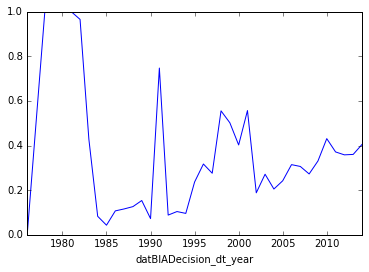

In [196]:
appeals_with_judge['datBIADecision_dt_year'] = appeals_with_judge['datBIADecision_dt'].dt.year 
last_year_grant_rate = appeals_with_judge.groupby('datBIADecision_dt_year')['granted'].mean()
last_year_grant_rate = pd.DataFrame(last_year_grant_rate).rename(columns={'granted': 'last_year_grant_rate'})
last_year_grant_rate['last_year_grant_rate'].plot()

In [197]:
# join to df 
appeals_with_judge['datAppealFiled_dt_year_before'] = appeals_with_judge['datAppealFiled_dt'].dt.year - 1 
appeals_with_last_year = appeals_with_judge.merge(last_year_grant_rate, how='left', 
                                                  left_on='datAppealFiled_dt_year_before', right_index=True)

### Preceeding Year Appeal Grant Rate - Segmented by Feature

In [198]:
# helper methods for Bayesian adjustment 

def calibrate_beta_priors(prior_mean, effective_sample_size): 
    """
    Takes aggregate rate and return Beta priors (alpha, beta) with prior mean approximating aggregate rate
    with respect to effective sample size chosen 
    """
    
    rounded_rate = np.round(prior_mean, 1)
    alpha = int(rounded_rate * effective_sample_size) 
    beta = effective_sample_size - alpha 
    
    return alpha, beta

def compute_posterior_mean(alpha_prior, beta_prior, num_positives, num_total): 
    """ 
    Takes Beta priors (alpha, beta) along with observed data (num_total, num_positives) 
    and returns posterior mean 
    """
    
    updated_alpha = alpha_prior + num_positives 
    updated_beta = beta_prior + num_total - num_positives 
    
    posterior_mean = float(updated_alpha) / (updated_alpha + updated_beta)
    
    return posterior_mean 

def compute_posterior_mean(alpha_prior, beta_prior, num_positives, num_total): 
    """ 
    Takes Beta priors (alpha, beta) along with observed data (num_total, num_positives) 
    and returns posterior mean 
    """
    
    updated_alpha = alpha_prior + num_positives 
    updated_beta = beta_prior + num_total - num_positives 
    
    posterior_mean = float(updated_alpha) / (updated_alpha + updated_beta)
    
    return posterior_mean

def get_beta_adj_rate(prior_mean, num_positives, num_total, prior_effective_size=10): 
    """ 
    Takes aggregate mean as a float (from 0 to 1), num_total (integer), and num_positives (integer) 
    and return the 'Beta-adjusted' rate. 
    Example: if in total 30% of Chinese nationality cases were granted, and a specific judge saw 20 cases 
    and granted 14 of them, input aggregate_mean=0.3, num_total=20, and num_positives=14 
    """
    
    if type(prior_mean) is not float: 
        raise ValueError("Please enter a float for prior mean!")
        
    if prior_mean < 0 or prior_mean > 1: 
        raise ValueError("Prior mean must be between 0 and 1!")
            
    alpha_prior, beta_prior = calibrate_beta_priors(prior_mean, prior_effective_size)
    posterior_mean = compute_posterior_mean(alpha_prior, beta_prior, num_positives, num_total)
    
    return posterior_mean

In [199]:
get_beta_adj_rate(prior_mean=.3, num_positives=14, num_total=20, prior_effective_size=0)

0.7

In [200]:
def last_year_grant_rate_by_feature(data, feature, last_year_grant_rate, prior_effective_size=10):
    df = data.groupby([feature, 'datBIADecision_dt_year', 'granted'])\
             .size().unstack().fillna(0).reset_index()\
             .rename(columns={0:'not_granted', 1:'granted'})
    df = df.merge(last_year_grant_rate, how='left', left_on='datBIADecision_dt_year', right_index=True)\
           .rename(columns={'datBIADecision_dt_year': 'datBIADecision_dt_year_'}) 
    new_feature_name = 'last_year_adj_grant_rate_by_{}'.format(feature)
    df[new_feature_name] = df.apply(
        lambda r: get_beta_adj_rate(r['last_year_grant_rate'], r['granted'], 
                                    r['granted'] + r['not_granted'], prior_effective_size), axis=1)
    results = data.merge(df[['datBIADecision_dt_year_', feature, new_feature_name]], how='left', 
                         left_on = ['datAppealFiled_dt_year_before', feature],
                         right_on = ['datBIADecision_dt_year_', feature])\
                  .drop('datBIADecision_dt_year_', axis=1)  
                    
    return results 

In [201]:
appeals_with_last_year = last_year_grant_rate_by_feature(appeals_with_last_year, 'ij_code_grouped', last_year_grant_rate,
                                                         prior_effective_size=10)

In [202]:
appeals_with_last_year = last_year_grant_rate_by_feature(appeals_with_last_year, 'nat_string_grouped', last_year_grant_rate,
                                                         prior_effective_size=10)

In [203]:
appeals_with_last_year['ij_code_nat'] = appeals_with_last_year['ij_code_grouped'] + '_' + appeals_with_last_year['nat_string_grouped']
appeals_with_last_year = last_year_grant_rate_by_feature(appeals_with_last_year, 'ij_code_nat', last_year_grant_rate,
                                                         prior_effective_size=10)

In [204]:
# fp = os.path.join(DATAFOLDER, 'data_for_model/data_all_features_2018-05-11-v2.csv') 
# appeals_with_last_year.to_csv(fp, index=False)

#### By Preceding Month 

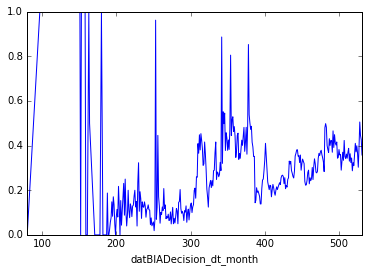

In [205]:
appeals_with_last_year['datBIADecision_dt_month'] = (appeals_with_last_year['datBIADecision_dt'].dt.year - 1970) * 12\
    + appeals_with_last_year['datBIADecision_dt'].dt.month    
monthly_grant_rate = appeals_with_last_year.groupby('datBIADecision_dt_month')['granted'].mean()
monthly_grant_rate = pd.DataFrame(monthly_grant_rate).rename(columns={'granted': 'monthly_grant_rate'})
monthly_grant_rate['monthly_grant_rate'].plot()

In [206]:
# join to df 
appeals_with_last_year['datAppealFiled_dt_month'] = (appeals_with_last_year['datAppealFiled_dt'].dt.year - 1970) * 12\
    + appeals_with_last_year['datAppealFiled_dt'].dt.month
appeals_with_last_year['datAppealFiled_dt_month_before'] = appeals_with_last_year['datAppealFiled_dt_month'] - 1
appeals_with_last_year = appeals_with_last_year.merge(monthly_grant_rate, how='left', 
                                                      left_on='datAppealFiled_dt_month_before', right_index=True)
appeals_with_last_year = appeals_with_last_year.rename(columns={'monthly_grant_rate': 'last_month_grant_rate'})

In [207]:
fp = os.path.join(DATAFOLDER, 'data_for_model/data_all_features_2018-05-11-v8.csv') 
appeals_with_last_year.to_csv(fp, index=False)

### Average Decision from Preceeding Appeals 

In [12]:
def break_into_chunks(data, dimension, max_chunk): 
    """ Returns a dictionary of lists to instruct breaking up dataset into suitable chunks, 
        where resulting rows from self-join on ij_code does not exceed max_df_rows """
    dimensions = pd.DataFrame(data.groupby(dimension).size().sort_values(ascending=False)) 
    dimensions = dimensions.rename(columns={0: 'rows'}).reset_index() 
    dimensions['self_join'] = dimensions['rows'] ** 2
    dimensions['self_join_cumulative'] = dimensions['self_join'].cumsum() 
    dimensions['chunk'] = np.floor(dimensions['self_join_cumulative'] / max_chunk).astype(int)
    chunk_assignments = dimensions.groupby('chunk')[dimension].apply(list).to_dict()
    print("Split {} labels in {} dimension into {} chunks...".format(len(dimensions), dimension, 
                                                                                  len(chunk_assignments)))
    return chunk_assignments

def compute_last_n_decisions_by_chunk(data_chunk, ref_chunk, dimension, last_n): 
    """ Run compute for a given chunk of data """
    df = data_chunk.merge(ref_chunk, how='left', on=dimension)
    results = df[df['datBIADecision_dt'] < df['datAppealFiled_dt']].groupby('idnAppeal').apply(
        lambda f: f.head(last_n)['granted'].mean()) 
    return results 

def compute_last_n_decisions(data, dimension, max_chunk=50000000, last_n=10): 
    """ Unified method to compute last n decisions """
    
    # get chunk assignments 
    chunk_assignments = break_into_chunks(data, dimension, max_chunk)
    
    # initialize empty list 
    results = [] 
    start = time.time() 
    
    # loop through each chunk 
    for chunk, selected in chunk_assignments.iteritems(): 
        start_chunk = time.time() 
        data_variables = ['idnAppeal', 'datAppealFiled_dt'] + [dimension]
        ref_variables = ['datBIADecision_dt', 'granted'] + [dimension] 
        data_chunk = data[data[dimension].isin(selected)][data_variables]
        ref_chunk = data[data[dimension].isin(selected)][ref_variables].sort_values(
            by=[dimension] + ['datBIADecision_dt'], ascending=[True, False])  
        result = compute_last_n_decisions_by_chunk(data_chunk, ref_chunk, dimension, last_n)
        results.append(result)
        print("Chunk {} completed in {} seconds".format(chunk, time.time() - start_chunk))
        
    print("DONE: Last {} decisions computed for {} dimension in {} seconds".format(last_n, dimension, 
                                                                             time.time() - start))
    return pd.concat(results) 

In [9]:
appeals_with_judge['ij_code_nat'] = appeals_with_judge['ij_code'] + '_' + appeals_with_judge['nat_string']
input_df = appeals_with_judge[['idnAppeal', 'datAppealFiled_dt', 'datBIADecision_dt', 'granted', 
                               'ij_code', 'nat_string', 'ij_code_nat']].copy()

In [15]:
# last 10 appeal grant rate by judge 
last_10_appeal_grant_by_judge = compute_last_n_decisions(input_df, 'ij_code', max_chunk=50000000, last_n=10)

Split 421 labels in ij_code dimension into 7 chunks...
Chunk 0 completed in 19.2041389942 seconds
Chunk 1 completed in 28.5545909405 seconds
Chunk 2 completed in 25.0906300545 seconds
Chunk 3 completed in 23.9727249146 seconds
Chunk 4 completed in 24.8628869057 seconds
Chunk 5 completed in 30.4491810799 seconds
Chunk 6 completed in 14.0754001141 seconds
DONE: Last 10 decisions computed for ij_code dimension in 166.210375071 seconds


In [ ]:
# last 10 appeal grant rate by nationality (this might cause memory issues because the biggest nationality exceeds max_chunk)
last_10_appeal_grant_by_nat = compute_last_n_decisions(input_df, 'nat_string', max_chunk=50000000, last_n=10)

Split 217 labels in nat_string dimension into 12 chunks...
Chunk 67 completed in 131.19086194 seconds
Chunk 69 completed in 53.5213148594 seconds
Chunk 71 completed in 39.8995580673 seconds
Chunk 72 completed in 15.9405970573 seconds
Chunk 73 completed in 27.2509388924 seconds
Chunk 74 completed in 24.8622629642 seconds
Chunk 75 completed in 23.8523321152 seconds
Chunk 76 completed in 26.6039559841 seconds


In [ ]:
# last 10 appeal grant rate by nationality (this might cause memory issues because the biggest nationality exceeds max_chunk)
last_10_appeal_grant_by_nat = compute_last_n_decisions(appeals_with_judge, 'nat_string', max_chunk=50000000, last_n=10)

Split 217 labels in nat_string dimension into 12 chunks...
Chunk 67 completed in 131.932816029 seconds
Chunk 69 completed in 49.9170689583 seconds
Chunk 71 completed in 32.7038171291 seconds
Chunk 72 completed in 16.851774931 seconds
Chunk 73 completed in 31.0073430538 seconds
Chunk 74 completed in 27.637750864 seconds
Chunk 75 completed in 26.6605019569 seconds
Chunk 76 completed in 36.9059078693 seconds


In [ ]:
# last 10 appeal grant rate by judge-nationality 
appeals_add['ij_code_nat'] = appeals_add['ij_code'] + '_' + appeals_add['nat_string']
last_10_appeal_grant_by_judge_nat = compute_last_n_decisions(appeals_add, 'ij_code_nat', max_chunk=50000000, last_n=10)

In [ ]:
appeals_add.merge(last_10_appeal_grant_by_judge, how='left', left_on='idnAppeal', right_index=True)